In [308]:
import numpy as np
import random
from random import randint
from gurobipy import *
import pandas as pd
from random import seed
from two_weights import *
import matplotlib.pyplot as plt

In [309]:
Manufacturing_plants = 2
Distribution = 3
Market = 4
Products = 2
Outsourced = 2
epsilon = 30

In [310]:
# Scenario parameters
a_si = [[1,1], [1,0], [0,1]] # don't include [0,0]
b_sj = [[1,1,1], [1,0,1], [1,1,0], [1,0,0], [0,1,1], [0,1,0], [0,0,1]] # don't include [0,0,0]

In [311]:
Scenarios = [[x,y] for x in a_si for y in b_sj]

In [312]:
Scenarios

[[[1, 1], [1, 1, 1]],
 [[1, 1], [1, 0, 1]],
 [[1, 1], [1, 1, 0]],
 [[1, 1], [1, 0, 0]],
 [[1, 1], [0, 1, 1]],
 [[1, 1], [0, 1, 0]],
 [[1, 1], [0, 0, 1]],
 [[1, 0], [1, 1, 1]],
 [[1, 0], [1, 0, 1]],
 [[1, 0], [1, 1, 0]],
 [[1, 0], [1, 0, 0]],
 [[1, 0], [0, 1, 1]],
 [[1, 0], [0, 1, 0]],
 [[1, 0], [0, 0, 1]],
 [[0, 1], [1, 1, 1]],
 [[0, 1], [1, 0, 1]],
 [[0, 1], [1, 1, 0]],
 [[0, 1], [1, 0, 0]],
 [[0, 1], [0, 1, 1]],
 [[0, 1], [0, 1, 0]],
 [[0, 1], [0, 0, 1]]]

In [313]:
num_Scenarios = len(Scenarios)
p_scen = 1/num_Scenarios

In [496]:
# Product Demand
demand = np.zeros((num_Scenarios, Products,Market))

In [497]:
distribution_mat = np.zeros((Products, Market,2))

In [498]:
distribution_mat[0][0][0] = 20
distribution_mat[0][1][0] = 25
distribution_mat[0][2][0] = 30
distribution_mat[0][3][0] = 35

distribution_mat[1][0][0] = 30
distribution_mat[1][1][0] = 35
distribution_mat[1][2][0] = 40
distribution_mat[1][3][0] = 45

distribution_mat[0][0][1] = 5
distribution_mat[0][1][1] = 3
distribution_mat[0][2][1] = 4
distribution_mat[0][3][1] = 2

distribution_mat[1][0][1] = 3
distribution_mat[1][1][1] = 4
distribution_mat[1][2][1] = 5
distribution_mat[1][3][1] = 6

In [499]:
distribution_mat

array([[[20.,  5.],
        [25.,  3.],
        [30.,  4.],
        [35.,  2.]],

       [[30.,  3.],
        [35.,  4.],
        [40.,  5.],
        [45.,  6.]]])

In [502]:
for s in range(num_Scenarios):
    for k in range(Market):
        for m in range(Products):
            demand[s][m][k] = np.round(np.random.normal(distribution_mat[m][k][0], distribution_mat[m][k][1]))

In [503]:
demand

array([[[11., 23., 34., 34.],
        [31., 42., 38., 38.]],

       [[18., 24., 32., 33.],
        [29., 36., 42., 36.]],

       [[27., 23., 23., 34.],
        [28., 33., 38., 49.]],

       [[23., 28., 30., 35.],
        [30., 36., 41., 43.]],

       [[19., 26., 33., 35.],
        [27., 31., 39., 48.]],

       [[23., 24., 23., 30.],
        [25., 39., 42., 39.]],

       [[20., 22., 37., 36.],
        [25., 29., 41., 44.]],

       [[18., 24., 33., 38.],
        [25., 32., 46., 50.]],

       [[17., 27., 23., 37.],
        [27., 36., 42., 45.]],

       [[19., 21., 29., 38.],
        [28., 38., 39., 49.]],

       [[22., 30., 34., 31.],
        [30., 42., 43., 46.]],

       [[19., 28., 28., 34.],
        [30., 24., 41., 36.]],

       [[24., 22., 33., 37.],
        [31., 36., 40., 45.]],

       [[18., 25., 34., 36.],
        [27., 36., 39., 39.]],

       [[16., 22., 32., 36.],
        [30., 38., 41., 57.]],

       [[18., 26., 28., 34.],
        [23., 35., 35., 46.]],

       [

In [504]:
total_demand = np.sum(demand)

In [505]:
total_demand

5417.0

In [506]:
# Cost of opening
f_i = [200, 50]
f_j = [75, 100, 50]

In [507]:
# Unit cost of manufacturing product
np.random.seed(0)
Manufacturing_costs = np.random.uniform(0,2, (Manufacturing_plants,Products))

In [508]:
# Unit cost of transporting m from plant to DC
np.random.seed(0)
Transportation_i_j = np.random.uniform(0,2, (Products, Manufacturing_plants, Distribution))

In [509]:
# Unit cost of transporting m from DC to Market Zone
np.random.seed(0)
Transportation_j_k = np.random.uniform(0,2, (Products, Distribution, Market))

In [510]:
Transportation_j_k

array([[[1.09762701, 1.43037873, 1.20552675, 1.08976637],
        [0.8473096 , 1.29178823, 0.87517442, 1.783546  ],
        [1.92732552, 0.76688304, 1.58345008, 1.05778984]],

       [[1.13608912, 1.85119328, 0.14207212, 0.1742586 ],
        [0.04043679, 1.66523969, 1.5563135 , 1.7400243 ],
        [1.95723668, 1.59831713, 0.92295872, 1.56105835]]])

In [511]:
# Plant Capacities: Bigger capacities for the more expensive ones
np.random.seed(0)
Capacities_i = np.zeros(Manufacturing_plants) # in volume (metres cubed)
Capacities_i[0] = np.random.randint(800,1000)
Capacities_i[1] = np.random.randint(200,400) 
Capacities_j = np.zeros(Distribution) # in volume (metres cubed)
Capacities_j[0] = np.random.randint(400, 600)
Capacities_j[1] = np.random.randint(600, 800)
Capacities_j[2] = np.random.randint(200,400)
Capacities_l = np.random.randint(50,100, (Products,Outsourced)) # in terms of products 

In [512]:
# Cost of purchasing product m from supplier l 
np.random.seed(0)
levels = 2
Supplier_cost = np.zeros((levels, Products, Outsourced))
Supplier_cost[0] = np.random.uniform(15, 20, (Products, Outsourced))
Supplier_cost[1] = np.random.randint(20, 25, (Products, Outsourced))

In [513]:
Supplier_cost

array([[[17.74406752, 18.57594683],
        [18.01381688, 17.72441591]],

       [[21.        , 23.        ],
        [22.        , 24.        ]]])

In [514]:
# Cost of transporting product m from outsourced facility l to j
np.random.seed(0)
T_O_DC = np.random.uniform(2, 5, (Products, Outsourced, Distribution))

In [515]:
# Cost of shipping product m from outsourced facility l to k
np.random.seed(0)
T_O_MZ = np.random.uniform(5, 7,(Products, Outsourced, Market))

In [516]:
# Product volume 
np.random.seed(0)
volume = np.random.uniform(2,3,(Products))

In [517]:
# unit cost of lost sales 
np.random.seed(40)
lost_sales = np.random.randint(18, 25,(Market,Products))

In [518]:
lost_sales

array([[24, 21],
       [23, 18],
       [18, 20],
       [19, 22]])

In [519]:
# Initialize model variables
x_i = {} # opening manufacturing plant
x_j = {} # opening DC
U_km = {} # quantity lost sales
V_lm = {} # quantity products purchased from outsourcing
Q_im = {} # quantity produced
Y_ijm = {} # shipping i -> j
Z_jkm = {} # shipping j -> k
T_ljm = {} # shipping l -> j
T_lkm = {} # shipping l -> k
y_lm = {} # indicator variable for step function 

# Dictionaries for analysis 
Cost_dict = {}
Summary_dict = {}
#recovered_demand = np.zeros((num_Scenarios, Products,Market))

## Deterministic Model

In [520]:
grbModel_det = Model('deterministic') # to obtain obj val of each scenario

In [521]:
def SetGurobiModel(scen):
    
    for i in range(Manufacturing_plants):
        x_i[i] = grbModel_det.addVar(vtype = GRB.BINARY)
    
    for j in range(Distribution):
        x_j[j] = grbModel_det.addVar(vtype = GRB.BINARY)
    
    for k in range(Market):
        for m in range(Products):
            U_km[k,m] = grbModel_det.addVar(vtype = GRB.INTEGER)
        
    for m in range(Products):
        for l in range(Outsourced):
            V_lm[m,l] = grbModel_det.addVar(vtype = GRB.INTEGER)
    
    for m in range(Products):
        for i in range(Manufacturing_plants):
            Q_im[m,i] = grbModel_det.addVar(vtype = GRB.INTEGER)
            
    for m in range(Products):
        for i in range(Manufacturing_plants):
            for j in range(Distribution):
                Y_ijm[m,i,j] = grbModel_det.addVar(vtype = GRB.INTEGER)                
    
    for m in range(Products):
        for j in range(Distribution):
            for k in range(Market): 
                Z_jkm[m,j,k] = grbModel_det.addVar(vtype = GRB.INTEGER)                
    
    for m in range(Products):
        for l in range(Outsourced):
            for j in range(Distribution):
                T_ljm[m,l,j] = grbModel_det.addVar(vtype = GRB.INTEGER)      
    
    for m in range(Products):
        for l in range(Outsourced):
            for k in range(Market):
                T_lkm[m,l,k] = grbModel_det.addVar(vtype = GRB.INTEGER)                
    
    for m in range(Products):
        for l in range(Outsourced):
            y_lm[m,l] = grbModel_det.addVar(vtype = GRB.BINARY)
                
    SetGrb_Obj()
    ModelCons(scen)


In [522]:
def SolveModel(scen):
    
    grbModel_det.params.OutputFlag = 0
    grbModel_det.optimize()
    
    # get variable values 
    v_val_x_i = grbModel_det.getAttr('x', x_i)
    v_val_x_j = grbModel_det.getAttr('x', x_j)
    v_val_U_km = grbModel_det.getAttr('x', U_km)
    v_val_V_lm = grbModel_det.getAttr('x', V_lm)
    v_val_Q_im = grbModel_det.getAttr('x', Q_im)
    v_val_Y_ijm = grbModel_det.getAttr('x', Y_ijm)
    v_val_Z_jkm = grbModel_det.getAttr('x', Z_jkm)
    v_val_T_ljm = grbModel_det.getAttr('x', T_ljm)
    v_val_T_lkm = grbModel_det.getAttr('x', T_lkm)
    v_val_y_lm = grbModel_det.getAttr('x', y_lm)    
    
    obj = grbModel_det.getObjective()
        
    return


In [523]:
# Objective

def SetGrb_Obj():

    grb_expr = LinExpr()

    # Cost of opening
    OC_1 = 0
    OC_2 = 0
    for i in range(Manufacturing_plants):
        OC_1 += f_i[i]*x_i[i]
    for j in range(Distribution):
        OC_2 += f_j[j]*x_j[j]    
        
    # Shipment 
    ship_1 = 0
    ship_2 = 0
    ship_3 = 0
    ship_4 = 0
    
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            for m in range(Products):
                ship_1 += Transportation_i_j[m][i][j]*Y_ijm[m,i,j]

    for j in range(Distribution):
        for k in range(Market):
            for m in range(Products):
                ship_2 += Transportation_j_k[m][j][k]*Z_jkm[m,j,k]

    for l in range(Outsourced):
        for j in range(Distribution):
            for m in range(Products):
                ship_3 += T_O_DC[m][l][j]*T_ljm[m,l,j]

    for l in range(Outsourced):
        for k in range(Market):
            for m in range(Products):
                ship_4 += T_O_MZ[m][l][k]*T_lkm[m,l,k]
                    
    total_shipment = ship_1 + ship_2 + ship_3 + ship_4

    # Production
    pr_cost = 0
    for i in range(Manufacturing_plants):
        for m in range(Products):
            pr_cost += Manufacturing_costs[i][m]*Q_im[m,i]                

    # Buying from outsource cost
    b_cost = 0
    for l in range(Outsourced):
        for m in range(Products):
            b_cost += Supplier_cost[0][m][l]*V_lm[m,l]*(1 - y_lm[m,l]) + (Supplier_cost[0][m][l]*epsilon + Supplier_cost[1][m][l]*(V_lm[m,l] - epsilon))*y_lm[m,l]

    #Lost Sales
    l_cost = 0
    for k in range(Market):
        for m in range(Products):
            l_cost += lost_sales[k][m]*U_km[k,m]                

    grb_expr += OC_1 + OC_2 + total_shipment + pr_cost + b_cost + l_cost
    
    grbModel_det.setObjective(grb_expr, GRB.MINIMIZE)
    
    return 

In [524]:
# Model Constraints

def ModelCons(scen):
    
    # Network Flow

    grbModel_det.addConstrs(Q_im[m,i] >= quicksum(Y_ijm[m,i,j] for j in range(Distribution)) 
                         for i in range(Manufacturing_plants) for m in range(Products))

    grbModel_det.addConstrs((quicksum(Y_ijm[m,i,j] for i in range(Manufacturing_plants)) +
                         quicksum(T_ljm[m,l,j] for l in range(Outsourced))) >= quicksum(Z_jkm[m,j,k] for k in range(Market))                        
                        for j in range(Distribution) for m in range(Products))

    grbModel_det.addConstrs((quicksum(Z_jkm[m,j,k] for j in range(Distribution)) +
                         quicksum(T_lkm[m,l,k] for l in range(Outsourced)) + U_km[k,m]) >= demand[s][m][k]
                         for k in range(Market) for m in range(Products))  
        
                    
    # Purchasing Constraints (everything purchased from outsourced facilities must be shipped)
    grbModel_det.addConstrs(V_lm[m,l] >= quicksum(T_ljm[m,l,j] for j in range(Distribution)) + 
                        quicksum(T_lkm[m,l,k] for k in range(Market))  
                        for m in range(Products) for l in range(Outsourced))
    
    
    # Capacity Constraints
    grbModel_det.addConstrs(quicksum(volume[m]*Q_im[m,i] for m in range(Products)) <= Scenarios[scen][0][i]*Capacities_i[i]*x_i[i] 
                         for i in range(Manufacturing_plants))
    
    grbModel_det.addConstrs(quicksum(volume[m]*Y_ijm[m,i,j] for i in range(Manufacturing_plants) for m in range(Products)) +
                        quicksum(volume[m]*T_ljm[m,l,j] for l in range(Outsourced) for m in range(Products)) <= 
                        Scenarios[scen][1][j]*Capacities_j[j]*x_j[j]  
                        for j in range(Distribution))
    
    grbModel_det.addConstrs((V_lm[m,l] <= (Capacities_l[m][l])) 
                        for l in range(Outsourced) for m in range(Products))
    
    
    # Indicator variable constraints for step function (25 is arbitrary)
    grbModel_det.addConstrs(V_lm[m,l] >= (epsilon + 1)*y_lm[m,l] for m in range(Products) for l in range(Outsourced))
    grbModel_det.addConstrs((V_lm[m,l] - (Capacities_l[m][l] - epsilon)*y_lm[m,l]) <= epsilon 
                               for m in range(Products) for l in range(Outsourced))
    
    return

In [525]:
def run_Model(scen):    
        
    SetGurobiModel(scen)
    SolveModel(scen)

In [526]:
scen_objs = []

In [527]:
for s in range(num_Scenarios):
    x_i = {} # opening manufacturing plant
    x_j = {} # opening DC
    U_km = {} # quantity lost sales
    V_lm = {} # quantity products purchased from outsourcing
    Q_im = {} # quantity produced
    Y_ijm = {} # shipping i -> j
    Z_jkm = {} # shipping j -> k
    T_ljm = {} # shipping l -> j
    T_lkm = {} # shipping l -> k
    y_lm = {} # indicator variable for step function 
    run_Model(s)
    scen_objs += [np.round(grbModel_det.objval,2)]

In [528]:
scen_objs

[1130.73,
 1119.21,
 1180.82,
 2144.04,
 1341.09,
 1342.13,
 3516.93,
 1159.36,
 1123.17,
 1204.1,
 2358.62,
 1278.72,
 1427.15,
 3572.71,
 3809.05,
 3283.71,
 3273.86,
 3802.18,
 3610.4,
 3907.97,
 3537.32]

In [529]:
penalty_weights = [scen_objs[0]/scen_objs[i] for i in range(num_Scenarios)]

In [530]:
penalty_weights = [50]*num_Scenarios

In [531]:
penalty_weights

[50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50]

## Stochastic Model

In [582]:
# Initialize model variables
x_i = {} # opening manufacturing plant
x_j = {} # opening DC
U_km = {} # quantity lost sales
V_lm = {} # quantity products purchased from outsourcing
Q_im = {} # quantity produced
Y_ijm = {} # shipping i -> j
Z_jkm = {} # shipping j -> k
T_ljm = {} # shipping l -> j
T_lkm = {} # shipping l -> k
y_lm = {} # indicator variable for step function 
delta_s = {} # penalty for p-robust
w_s = {} # reward for meeting demand above specified rate

# Dictionaries for analysis 
Cost_dict = {}
Summary_dict = {}

# Dictionary to weigh different objectives 
objWeights = {} 

# Dictionary to save values of each objectives
dic_grbOut = {}

In [583]:
dem_penalties = np.random.uniform(18, 32, num_Scenarios)

In [584]:
dem_penalties 

array([26.62916296, 20.36140062, 23.00375766, 19.33602834, 25.46899017,
       21.9726016 , 28.65311724, 30.87032029, 27.4461264 , 29.56551203,
       31.7006665 , 19.13905052, 25.32881295, 21.52499601, 27.94243269,
       18.83222809, 26.01063081, 29.30486469, 24.84998777, 21.39488658,
       24.76874867])

In [585]:
grbModel = Model('stochastic')

In [586]:
def SetGurobiModel(p, rl):
    
    for i in range(Manufacturing_plants):
        x_i[i] = grbModel.addVar(vtype = GRB.BINARY)
    
    for j in range(Distribution):
        x_j[j] = grbModel.addVar(vtype = GRB.BINARY)
    
    for s in range(num_Scenarios):
        for k in range(Market):
            for m in range(Products):
                U_km[s,k,m] = grbModel.addVar(vtype = GRB.CONTINUOUS)
        
    for s in range(num_Scenarios):
        for m in range(Products):
            for l in range(Outsourced):
                V_lm[s,m,l] = grbModel.addVar(vtype = GRB.CONTINUOUS)
    
    for s in range(num_Scenarios):
        for m in range(Products):
            for i in range(Manufacturing_plants):
                Q_im[s,m,i] = grbModel.addVar(vtype = GRB.CONTINUOUS)
            
    for s in range(num_Scenarios):  
        for m in range(Products):
            for i in range(Manufacturing_plants):
                for j in range(Distribution):
                    Y_ijm[s,m,i,j] = grbModel.addVar(vtype = GRB.CONTINUOUS)                
    
    for s in range(num_Scenarios):
        for m in range(Products):
            for j in range(Distribution):
                for k in range(Market): 
                    Z_jkm[s,m,j,k] = grbModel.addVar(vtype = GRB.CONTINUOUS)                
    
    for s in range(num_Scenarios):
        for m in range(Products):
            for l in range(Outsourced):
                for j in range(Distribution):
                    T_ljm[s,m,l,j] = grbModel.addVar(vtype = GRB.CONTINUOUS)      
    
    for s in range(num_Scenarios):
        for m in range(Products):
            for l in range(Outsourced):
                for k in range(Market):
                    T_lkm[s,m,l,k] = grbModel.addVar(vtype = GRB.CONTINUOUS)                
    
    for s in range(num_Scenarios):
        for m in range(Products):
            for l in range(Outsourced):
                y_lm[s,m,l] = grbModel.addVar(vtype = GRB.BINARY)
                
    for s in range(num_Scenarios):
        delta_s[s] = grbModel.addVar(vtype = GRB.CONTINUOUS)
        
    for s in range(num_Scenarios):
        for k in range(Market):
            for m in range(Products):
                w_s[s,k,m] = grbModel.addVar(vtype = GRB.BINARY)
                
    SetGrb_Obj()
    ModelCons(p, rl)

In [587]:
def SolveModel():
    
    grbModel.params.OutputFlag = 0
    grbModel.optimize()
    
    # get variable values 
    v_val_x_i = grbModel.getAttr('x', x_i)
    v_val_x_j = grbModel.getAttr('x', x_j)
    v_val_U_km = grbModel.getAttr('x', U_km)
    v_val_V_lm = grbModel.getAttr('x', V_lm)
    v_val_Q_im = grbModel.getAttr('x', Q_im)
    v_val_Y_ijm = grbModel.getAttr('x', Y_ijm)
    v_val_Z_jkm = grbModel.getAttr('x', Z_jkm)
    v_val_T_ljm = grbModel.getAttr('x', T_ljm)
    v_val_T_lkm = grbModel.getAttr('x', T_lkm)
    v_val_y_lm = grbModel.getAttr('x', y_lm)
    v_val_delta_s = grbModel.getAttr('x', delta_s)
    v_val_w = grbModel.getAttr('x', w_s)
    
    obj = grbModel.getObjective()
    print("obj val: ", obj.getValue())   
    
    Summary_dict['ObjVal'] = grbModel.objval
    Summary_dict["OpenMPs"] = np.sum(v_val_x_i.values())
    Summary_dict["OpenDCs"] = np.sum(v_val_x_j.values())
    Cost_dict["Opening"] =  get_opening_costs(v_val_x_i, v_val_x_j)
    Cost_dict["pr_Penalties"] = np.round(p_scen*get_pr_penalty_costs(v_val_delta_s), 2)
    Cost_dict["f2"] = np.round(p_scen*get_rl_rate(v_val_w))
    
    for s in range(num_Scenarios):        
        Summary_dict["Purchasing_" + str(s)] = sum([v_val_V_lm[(s,m,l)] for m in range(Products) for l in range(Outsourced)])    
        Summary_dict["Production_" + str(s)] = sum([v_val_Q_im[(s,m,i)] for m in range(Products) for i in range(Manufacturing_plants)])
        Summary_dict["LostSales_" + str(s)] = sum([v_val_U_km[(s,k,m)] for m in range(Products) for k in range(Market)])
        Summary_dict["OutsourceToDC_" + str(s)] = sum([v_val_T_ljm[(s,m,l,j)] for m in range(Products) for l in range(Outsourced) for j in range(Distribution)])
        Summary_dict["OutsourceToMarket_" + str(s)] = sum([v_val_T_lkm[(s,m,l,k)] for m in range(Products) for l in range(Outsourced) for k in range(Market)])        
        
    for s in range(num_Scenarios):
        Cost_dict["InHouseShipping_" + str(s)] = get_shipping_costs(s,v_val_Y_ijm, v_val_Z_jkm, v_val_T_ljm, v_val_T_lkm)[0]
        Cost_dict["OutsourceShipping_" + str(s)] = get_shipping_costs(s,v_val_Y_ijm, v_val_Z_jkm, v_val_T_ljm, v_val_T_lkm)[1]
        Cost_dict["Production_" + str(s)] = get_production_cost(s,v_val_Q_im)
        Cost_dict["Purchasing_" + str(s)] = get_purchase_costs(s,v_val_V_lm, v_val_y_lm)
        Cost_dict["LostSales_" + str(s)] = get_lost_cost(s,v_val_U_km)
    
    Purchasing_cost = np.sum([Cost_dict['Purchasing_' + str(s)] for s in range(num_Scenarios)])
    Production_cost = np.sum([Cost_dict['Production_' + str(s)] for s in range(num_Scenarios)])
    LostSales_cost = np.sum([Cost_dict['LostSales_' + str(s)] for s in range(num_Scenarios)])
    InHouseShipping = np.sum([Cost_dict['InHouseShipping_' + str(s)] for s in range(num_Scenarios)])
    OutsourceShipping = np.sum([Cost_dict['OutsourceShipping_' + str(s)] for s in range(num_Scenarios)])
    
    Cost_dict["f1"] = np.round(Cost_dict["Opening"] + p_scen*(Purchasing_cost + Production_cost + LostSales_cost + InHouseShipping + OutsourceShipping) + Cost_dict['pr_Penalties'], 2)

    return

In [588]:
# Objective

def SetGrb_Obj():

    grb_expr = LinExpr()

    # Cost of opening
    OC_1 = 0
    OC_2 = 0
    for i in range(Manufacturing_plants):
        OC_1 += f_i[i]*x_i[i]
    for j in range(Distribution):
        OC_2 += f_j[j]*x_j[j]       
    
    total_shipment = 0    
    total_pr_cost = 0
    total_b_cost = 0
    total_l_cost = 0
    
    # Shipment 

    for s in range(num_Scenarios):
        ship_1 = 0
        ship_2 = 0
        ship_3 = 0
        ship_4 = 0
        for i in range(Manufacturing_plants):
            for j in range(Distribution):
                for m in range(Products):
                    ship_1 += Transportation_i_j[m][i][j]*Y_ijm[s,m,i,j]

        for j in range(Distribution):
            for k in range(Market):
                for m in range(Products):
                    ship_2 += Transportation_j_k[m][j][k]*Z_jkm[s,m,j,k]

        for l in range(Outsourced):
            for j in range(Distribution):
                for m in range(Products):
                    ship_3 += T_O_DC[m][l][j]*T_ljm[s,m,l,j]

        for l in range(Outsourced):
            for k in range(Market):
                for m in range(Products):
                    ship_4 += T_O_MZ[m][l][k]*T_lkm[s,m,l,k]
                    
        total_shipment += ship_1 + ship_2 + ship_3 + ship_4

        # Production
        pr_cost = 0
        for i in range(Manufacturing_plants):
            for m in range(Products):
                pr_cost += Manufacturing_costs[i][m]*Q_im[s,m,i]
                
        total_pr_cost += pr_cost

        # Buying from outsource cost
        b_cost = 0
        for l in range(Outsourced):
            for m in range(Products):
                b_cost += Supplier_cost[0][m][l]*V_lm[s,m,l]*(1 - y_lm[s,m,l]) + \
                (Supplier_cost[0][m][l]*epsilon + Supplier_cost[1][m][l]*(V_lm[s,m,l] - epsilon))*y_lm[s,m,l]
                
        total_b_cost += b_cost

        #Lost Sales
        l_cost = 0
        for k in range(Market):
            for m in range(Products):
                l_cost += lost_sales[k][m]*U_km[s,k,m]
                
        total_l_cost += l_cost   

    # Penalties
    p_robust_penalties = 0
    for s in range(num_Scenarios):
        p_robust_penalties += penalty_weights[s]*delta_s[s]    
        
    
    # Percentage of demand met
    rl_penalty = 0
    for s in range(num_Scenarios):
        for k in range(Market):
            for m in range(Products):
                rl_penalty += lost_sales[k][m]*w_s[s,k,m]*demand[s][m][k]       
    
    grb_expr += objWeights['f1']*(OC_1 + OC_2 + p_scen*(total_shipment + total_pr_cost + total_b_cost + total_l_cost) + \
  p_scen*p_robust_penalties) + objWeights['f2']*p_scen*rl_penalty

    
    grbModel.setObjective(grb_expr, GRB.MINIMIZE)
    
    return 


In [589]:
# Model Constraints

def ModelCons(p, rl):
    
    # Network Flow

    grbModel.addConstrs(Q_im[s,m,i] >= quicksum(Y_ijm[s,m,i,j] for j in range(Distribution)) 
                         for s in range(num_Scenarios) for i in range(Manufacturing_plants) for m in range(Products))

    grbModel.addConstrs((quicksum(Y_ijm[s,m,i,j] for i in range(Manufacturing_plants)) +
                         quicksum(T_ljm[s,m,l,j] for l in range(Outsourced))) >= quicksum(Z_jkm[s,m,j,k] for k in range(Market))                        
                        for s in range(num_Scenarios) for j in range(Distribution) for m in range(Products))
    
    grbModel.addConstrs(quicksum(Z_jkm[s,m,j,k] for j in range(Distribution)) + 
                        quicksum(T_lkm[s,m,l,k] for l in range(Outsourced)) + 
                        U_km[s,k,m] >= demand[s][m][k] for s in range(num_Scenarios) for m in range(Products)
                        for k in range(Market))
    
    #grbModel.addConstrs(quicksum(Z_jkm[s,m,j,k] for j in range(Distribution)) + 
     #                   quicksum(T_lkm[s,m,l,k] for l in range(Outsourced)) <= demand[s][m][k] for s in range(num_Scenarios) for m in range(Products)
      #                  for k in range(Market))
        
                    
    # Purchasing Constraints (everything purchased from outsourced facilities must be shipped)
    grbModel.addConstrs(V_lm[s,m,l] >= quicksum(T_ljm[s,m,l,j] for j in range(Distribution)) + 
                        quicksum(T_lkm[s,m,l,k] for k in range(Market)) for s in range(num_Scenarios) 
                        for m in range(Products) for l in range(Outsourced))
    
    # Purchasing Constraints (can only outsource in disruption)
        
    # Capacity Constraints
    grbModel.addConstrs(quicksum(volume[m]*Q_im[s,m,i] for m in range(Products)) <= Scenarios[s][0][i]*Capacities_i[i]*x_i[i] 
                        for s in range(num_Scenarios) for i in range(Manufacturing_plants))
    
    grbModel.addConstrs(quicksum(volume[m]*Y_ijm[s,m,i,j] for i in range(Manufacturing_plants) for m in range(Products)) +
                        quicksum(volume[m]*T_ljm[s,m,l,j] for l in range(Outsourced) for m in range(Products)) <= 
                        Scenarios[s][1][j]*Capacities_j[j]*x_j[j] for s in range(num_Scenarios) for s in range(num_Scenarios)
                        for j in range(Distribution))
    
    grbModel.addConstrs((V_lm[s,m,l] <= (Capacities_l[m][l])) for s in range(num_Scenarios)
                        for l in range(Outsourced) for m in range(Products))
    
    
    # Indicator variable constraints for step function (25 is arbitrary)
    grbModel.addConstrs(V_lm[s,m,l] >= (epsilon + 1)*y_lm[s,m,l] for s in range(num_Scenarios) 
                        for m in range(Products) for l in range(Outsourced))
    
    grbModel.addConstrs((V_lm[s,m,l] - (Capacities_l[m][l] - epsilon)*y_lm[s,m,l])
                         <= epsilon for s in range(num_Scenarios) for m in range(Products) for l in range(Outsourced))   
    
    
    #Demand Metric (w = 1 if demand met is below rl)
    grbModel.addConstrs((U_km[s,k,m]/demand[s][m][k]) - (rl + 0.0001)*w_s[s,k,m] <= 1 - rl - 0.0001
                        for s in range(num_Scenarios) for k in range(Market) for m in range(Products))    

    
    #P-robust metric    
    grbModel.addConstrs(quicksum(f_i[i]*x_i[i] for i in range(Manufacturing_plants))
                        + quicksum(f_j[j]*x_j[j] for j in range(Distribution))
                        + quicksum(Transportation_i_j[m][i][j]*Y_ijm[s,m,i,j] for i in range(Manufacturing_plants) 
                                  for j in range(Distribution) for m in range(Products))
                        + quicksum(Transportation_j_k[m][j][k]*Z_jkm[s,m,j,k] for j in range(Distribution)
                                   for k in range(Market) for m in range(Products))
                        + quicksum(T_O_DC[m][l][j]*T_ljm[s,m,l,j] for l in range(Outsourced) for j in range(Distribution)
                                   for m in range(Products))
                        + quicksum(T_O_MZ[m][l][k]*T_lkm[s,m,l,k] for l in range(Outsourced) for k in range(Market)
                                   for m in range(Products))
                        + quicksum(Manufacturing_costs[i][m]*Q_im[s,m,i] for i in range(Manufacturing_plants) 
                                   for m in range(Products))
                        + quicksum(Supplier_cost[0][m][l]*V_lm[s,m,l]*(1 - y_lm[s,m,l]) + \
                (Supplier_cost[0][m][l]*epsilon + Supplier_cost[1][m][l]*(V_lm[s,m,l] - epsilon))*y_lm[s,m,l]
                                   for l in range(Outsourced) for m in range(Products))
                        + quicksum(lost_sales[k][m]*U_km[s,k,m] for k in range(Market) for m in range(Products)) - delta_s[s]
                        
                        <= (1 + p)*scen_objs[s] for s in range(num_Scenarios))                                 
                                                                    
    
    return   


In [590]:
def get_opening_costs(x1, x2):
    
    # Cost of opening
    OC_1 = 0
    OC_2 = 0
    for i in range(Manufacturing_plants):
        OC_1 += f_i[i]*x1[i]
    for j in range(Distribution):
        OC_2 += f_j[j]*x2[j]

    Opening = np.round(OC_1 + OC_2)
    
    return(Opening)
   
def get_shipping_costs(scen, Y, Z, T1, T2):
    ship_1 = 0
    ship_2 = 0
    ship_3 = 0
    ship_4 = 0

    # Shipment
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            for m in range(Products):
                ship_1 += Transportation_i_j[m][i][j]*Y[scen, m,i,j]

    for j in range(Distribution):
        for k in range(Market):
            for m in range(Products):
                ship_2 += Transportation_j_k[m][j][k]*Z[scen,m,j,k]

    for l in range(Outsourced):
        for j in range(Distribution):
            for m in range(Products):
                ship_3 += T_O_DC[m][l][j]*T1[scen,m,l,j]

    for l in range(Outsourced):
        for k in range(Market):
            for m in range(Products):
                ship_4 += T_O_MZ[m][l][k]*T2[scen,m,l,k]
    
    in_house_shipping = np.round(ship_1 + ship_2)

    outsourced_shipping = np.round(ship_3 + ship_4)
    
    return(in_house_shipping, outsourced_shipping)

def get_production_cost(scen, Q):

    # Production
    pr_cost = 0
    for i in range(Manufacturing_plants):
        for m in range(Products):
            pr_cost += Manufacturing_costs[i][m]*Q[scen,m,i]
            
    return(np.round(pr_cost))

def get_purchase_costs(scen, V, y):    

    # Buying from outsource cost
    b_cost = 0
    for l in range(Outsourced):
        for m in range(Products):
            b_cost += Supplier_cost[0][m][l]*V[scen,m,l]*(1 - y[scen,m,l]) + (Supplier_cost[0][m][l]*epsilon + Supplier_cost[1][m][l]*(V[scen,m,l] - epsilon))*y[scen,m,l]          

    return(np.round(b_cost))

def get_lost_cost(scen,U):
    
    #Lost Sales
    l_cost = 0
    for k in range(Market):
        for m in range(Products):
            l_cost += lost_sales[k][m]*U[scen,k,m]
            
    return(np.round(l_cost))

def get_pr_penalty_costs(delta):
    penalties = 0
    for s in range(num_Scenarios):
        penalties += penalty_weights[s]*delta[s]
    return(penalties)

def get_rl_rate(w):
    rl_penalty = 0
    for s in range(num_Scenarios):
        for k in range(Market):
            for m in range(Products):
                rl_penalty += lost_sales[k][m]*w[s,k,m]*distribution_mat[m][k][0]    
    
    return(rl_penalty)

In [591]:
def run_Model(p, rl, objDict):
    for key, value in objDict.items():
        objWeights[key] = value
        
    SetGurobiModel(p, rl)
    SolveModel()

In [592]:
def dict_to_dataframe(Dict):
    return pd.DataFrame([list(Dict.values())], columns = list(Dict.keys()))

In [593]:
run_Model(0.2, 0.95, {'f1': 1, 'f2': 1})

obj val:  3129.4718966294467


In [594]:
num_correct = 0
for s in range(num_Scenarios):
    if np.round((Summary_dict['Purchasing_'+str(s)] + Summary_dict['Production_' + str(s) ] + Summary_dict['LostSales_' + str(s)])) == np.sum(demand[s]):
        num_correct += 1
    else:
        print (np.round(Summary_dict['Purchasing_'+str(s)] + Summary_dict['Production_' + str(s) ] + Summary_dict['LostSales_' + str(s)]))
        print(np.sum(demand[s]))
        (print(s))
    
num_correct == num_Scenarios

True

In [595]:
num_correct

21

In [596]:
Purchasing = [Summary_dict['Purchasing_' + str(s)] for s in range(num_Scenarios)]
Production = [Summary_dict['Production_' + str(s)] for s in range(num_Scenarios)]
LostSales = [Summary_dict['LostSales_' + str(s)] for s in range(num_Scenarios)]
OutsourceToDC = [Summary_dict['OutsourceToDC_' + str(s)] for s in range(num_Scenarios)]
OutsourceToMarket = [Summary_dict['OutsourceToMarket_' + str(s)] for s in range(num_Scenarios)]

In [597]:
Unit_df = pd.DataFrame(list(zip(Purchasing, Production, LostSales, OutsourceToDC, OutsourceToMarket)), 
             columns = ["Purchasing", "Production", "LostSales", "OutsourceToDC", "OutsourceToMarket"])

In [598]:
np.round(Unit_df)

,Purchasing,Production,LostSales,OutsourceToDC,OutsourceToMarket
0,0.0,251.0,0.0,0.0,0.0
1,0.0,250.0,0.0,0.0,0.0
2,0.0,255.0,0.0,0.0,0.0
3,31.0,196.0,39.0,0.0,31.0
4,0.0,258.0,0.0,0.0,0.0
5,0.0,242.0,3.0,0.0,0.0
6,106.0,100.0,48.0,0.0,106.0
7,0.0,266.0,0.0,0.0,0.0
8,0.0,254.0,0.0,0.0,0.0
9,0.0,261.0,0.0,0.0,0.0


In [599]:
1 - np.array(list(Unit_df['LostSales']))/(np.array(list(Unit_df['Purchasing'])) + np.array(list(Unit_df['Production'])) + (np.array(list(Unit_df['LostSales']))))

array([1.        , 1.        , 1.        , 0.85251316, 1.        ,
       0.98920531, 0.81169961, 1.        , 1.        , 1.        ,
       0.84323453, 1.        , 0.99810053, 0.81544016, 0.81736544,
       0.81803755, 0.8284749 , 0.69510257, 0.82994721, 0.71624412,
       0.70379255])

In [600]:
Purchasing_cost = [Cost_dict['Purchasing_' + str(s)] for s in range(num_Scenarios)]
Production_cost = [Cost_dict['Production_' + str(s)] for s in range(num_Scenarios)]
LostSales_cost = [Cost_dict['LostSales_' + str(s)] for s in range(num_Scenarios)]
InHouseShipping = [Cost_dict['InHouseShipping_' + str(s)] for s in range(num_Scenarios)]
OutsourceShipping = [Cost_dict['OutsourceShipping_' + str(s)] for s in range(num_Scenarios)]

In [601]:
Cost_dict['f1'] + Cost_dict['f2']

3108.57

In [602]:
grbModel.objVal

3129.4718966294445

In [603]:
Cost_df = pd.DataFrame(list(zip(Purchasing_cost, Production_cost, LostSales_cost, InHouseShipping, OutsourceShipping)), 
             columns = ["Purchasing", "Production", "LostSales", "InHouseShipping", "OutsourceShipping"])

In [604]:
Cost_df

,Purchasing,Production,LostSales,InHouseShipping,OutsourceShipping
0,0.0,309.0,0.0,443.0,0.0
1,0.0,291.0,0.0,461.0,0.0
2,0.0,312.0,0.0,449.0,0.0
3,562.0,221.0,725.0,332.0,181.0
4,0.0,300.0,0.0,641.0,0.0
5,0.0,325.0,49.0,661.0,0.0
6,1904.0,109.0,891.0,231.0,606.0
7,0.0,343.0,0.0,478.0,0.0
8,0.0,329.0,0.0,469.0,0.0
9,0.0,338.0,0.0,491.0,0.0


In [605]:
Summary_dict["OpenMPs"]

2.0

In [606]:
Summary_dict["OpenDCs"]

3.0

In [607]:
scen_costs = [Cost_dict['Opening'] + Purchasing_cost[s] + Production_cost[s] + InHouseShipping[s] + OutsourceShipping[s] + LostSales_cost[s] for s in range(num_Scenarios)]

In [608]:
(np.array(scen_costs) - np.array(scen_objs))/np.array(scen_objs)

array([0.08513969, 0.096309  , 0.04673024, 0.16415739, 0.05585755,
       0.1250773 , 0.19877279, 0.11785813, 0.13339922, 0.08296653,
       0.18755883, 0.09797297, 0.12742178, 0.18593449, 0.18454733,
       0.19163994, 0.18025817, 0.14539554, 0.19792821, 0.17375517,
       0.18677417])

In [609]:
Cost_dict['f1']

2714.57

In [610]:
Cost_dict['f2']

394.0

In [611]:
Cost_dict['pr_Penalties']

0.0

In [612]:
delta_s

{0: <gurobi.Var C1769 (value 0.0)>,
 1: <gurobi.Var C1770 (value 0.0)>,
 2: <gurobi.Var C1771 (value 0.0)>,
 3: <gurobi.Var C1772 (value 0.0)>,
 4: <gurobi.Var C1773 (value 0.0)>,
 5: <gurobi.Var C1774 (value 0.0)>,
 6: <gurobi.Var C1775 (value 0.0)>,
 7: <gurobi.Var C1776 (value 0.0)>,
 8: <gurobi.Var C1777 (value 0.0)>,
 9: <gurobi.Var C1778 (value 0.0)>,
 10: <gurobi.Var C1779 (value 0.0)>,
 11: <gurobi.Var C1780 (value 0.0)>,
 12: <gurobi.Var C1781 (value 0.0)>,
 13: <gurobi.Var C1782 (value 0.0)>,
 14: <gurobi.Var C1783 (value 0.0)>,
 15: <gurobi.Var C1784 (value 0.0)>,
 16: <gurobi.Var C1785 (value 0.0)>,
 17: <gurobi.Var C1786 (value 0.0)>,
 18: <gurobi.Var C1787 (value 0.0)>,
 19: <gurobi.Var C1788 (value 0.0)>,
 20: <gurobi.Var C1789 (value 0.0)>}

In [613]:
U = grbModel.getAttr('x',U_km)

In [614]:
U_km_mat = np.zeros((21,2,4))
for s in range(num_Scenarios):
    for k in range(Market):
        for m in range(Products):
            U_km_mat[s,m,k] = U[s,k,m]

In [615]:
demand_met = 1 - U_km_mat.reshape((168))/np.array(demand).reshape((168))

In [616]:
np.round(demand_met)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., -0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1., -0.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.])

In [617]:
(demand_met).reshape(21,2,4)

array([[[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00]],

       [[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00]],

       [[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00]],

       [[ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          9.50100000e-01],
        [ 9.50100000e-01,  9.50100000e-01,  9.50100000e-01,
          9.50100000e-01]],

       [[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00],
        [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
          1.00000000e+00]],

       [[ 1.00000000e+00,  1.00000000e+00,  9.50100000e-01,
          9.50100000e-01],
        [ 1.00000000e+00,  1.0000

In [618]:
w = grbModel.getAttr('x',w_s)

In [619]:
w_mat = np.zeros((21,2,4))
for s in range(num_Scenarios):
    for k in range(Market):
        for m in range(Products):
            w_mat[s,m,k] = w[s,k,m]

In [620]:
w_mat

array([[[-0., -0., -0., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0., -0., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0., -0., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0.,  1., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0., -0., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0., -0., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0.,  1., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0., -0., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0., -0., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0., -0., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0.,  1., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0., -0., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0., -0., -0.],
        [-0., -0., -0., -0.]],

       [[-0., -0., -0., -0.],
        [-0.,  1., -0., -0.]],

       [[-0., -0.,  0., -0.],
        [-0.,  1., -0., -0.]],

       [[-0., -0., -0., -0.],
        [-0.,  1., -0., -0.]],

       [

## Comparing different weights for objective values 

In [621]:
dictionaries = []
for weights in weights_20:
    dictionary = {'f1': weights[0], 'f2': weights[1]}
    dictionaries.append(dictionary)

In [622]:
dictionaries

[{'f1': 0.0, 'f2': 1.0},
 {'f1': 0.05, 'f2': 0.95},
 {'f1': 0.1, 'f2': 0.9},
 {'f1': 0.15, 'f2': 0.85},
 {'f1': 0.2, 'f2': 0.8},
 {'f1': 0.25, 'f2': 0.75},
 {'f1': 0.3, 'f2': 0.7},
 {'f1': 0.35, 'f2': 0.65},
 {'f1': 0.4, 'f2': 0.6},
 {'f1': 0.45, 'f2': 0.55},
 {'f1': 0.5, 'f2': 0.5},
 {'f1': 0.55, 'f2': 0.45},
 {'f1': 0.6, 'f2': 0.4},
 {'f1': 0.65, 'f2': 0.35},
 {'f1': 0.7, 'f2': 0.3},
 {'f1': 0.75, 'f2': 0.25},
 {'f1': 0.8, 'f2': 0.2},
 {'f1': 0.85, 'f2': 0.15},
 {'f1': 0.9, 'f2': 0.1},
 {'f1': 0.95, 'f2': 0.05},
 {'f1': 1.0, 'f2': 0.0}]

In [623]:
## Configuration 1 
p = 0.2
rl = 0.99
objective_vals = []
for Dict in dictionaries:
    run_Model(p, rl, Dict)
    objective_vals.append([Dict['f1'], Dict['f2'], Cost_dict['f1'], Cost_dict['f2'], Summary_dict["OpenMPs"], Summary_dict["OpenDCs"]])

obj val:  0.0
obj val:  484.8725507127047
obj val:  654.5200234120664
obj val:  787.0133991432954
obj val:  907.6962406679336
obj val:  1021.39034702218
obj val:  1139.395914707296
obj val:  1248.632200116765
obj val:  1363.1129345825484
obj val:  1476.162765691083
obj val:  1587.8438901139004
obj val:  1702.2624279081485
obj val:  1813.064295714888
obj val:  1924.4188899649923
obj val:  2035.5553991405577
obj val:  2146.35407496675
obj val:  2253.9973467467103
obj val:  2346.642250056097
obj val:  2423.5429776726705
obj val:  2490.4515466115677
obj val:  2546.144583293276


In [624]:
df_1 = pd.DataFrame((objective_vals), columns = ["f1 weight", "f2 weight", "f1", "f2", "Plants", "DCs"])
df_1

,f1 weight,f2 weight,f1,f2,Plants,DCs
0,0.00,1.00,37842.38,0.0,2.0,3.0
1,0.05,0.95,4632.62,270.0,2.0,3.0
2,0.10,0.90,3374.56,347.0,2.0,3.0
3,0.15,0.85,2926.61,394.0,2.0,3.0
4,0.20,0.80,2828.18,429.0,2.0,3.0
5,0.25,0.75,2725.62,467.0,2.0,3.0
6,0.30,0.70,2724.14,471.0,2.0,3.0
7,0.35,0.65,2725.67,467.0,2.0,3.0
8,0.40,0.60,2719.71,467.0,2.0,3.0
9,0.45,0.55,2719.67,467.0,2.0,3.0


In [625]:
f2_1 = list(df_1['f2'])
f1_1 = list(df_1['f1'])

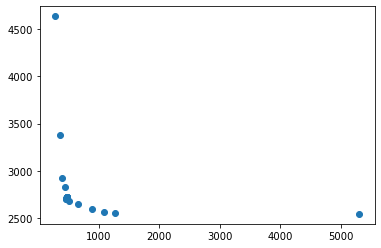

In [642]:
plt.scatter(f2_1[1:], f1_1[1:])

In [627]:
## Configuration 2 
p = 0.2
rl = 0.9
objective_vals = []
for Dict in dictionaries:
    run_Model(p, rl, Dict)
    objective_vals.append([Dict['f1'], Dict['f2'], Cost_dict['f1'], Cost_dict['f2'], Summary_dict["OpenMPs"], Summary_dict["OpenDCs"]])

obj val:  0.0
obj val:  381.75394391437965
obj val:  554.7772656482688
obj val:  687.9208960571435
obj val:  813.4377164867104
obj val:  937.9995265607705
obj val:  1062.5613366348232
obj val:  1186.9404353050998
obj val:  1307.4198044348423
obj val:  1424.9387992178317
obj val:  1542.4134843514776
obj val:  1658.8548327866235
obj val:  1773.9840311725115
obj val:  1889.6805419626064
obj val:  2005.046305702538
obj val:  2120.4099861378127
obj val:  2234.286648454959
obj val:  2333.6656071719967
obj val:  2417.7381618665113
obj val:  2487.354519449947
obj val:  2546.144583293276


In [628]:
df_2 = pd.DataFrame((objective_vals), columns = ["f1 weight", "f2 weight", "f1", "f2", "Plants", "DCs"])
df_2

,f1 weight,f2 weight,f1,f2,Plants,DCs
0,0.00,1.00,35443.05,0.0,2.0,3.0
1,0.05,0.95,5876.20,90.0,2.0,3.0
2,0.10,0.90,3048.29,283.0,2.0,3.0
3,0.15,0.85,2853.50,315.0,2.0,3.0
4,0.20,0.80,2806.41,319.0,2.0,3.0
5,0.25,0.75,2806.37,319.0,2.0,3.0
6,0.30,0.70,2806.41,319.0,2.0,3.0
7,0.35,0.65,2800.70,317.0,2.0,3.0
8,0.40,0.60,2745.33,347.0,2.0,3.0
9,0.45,0.55,2704.62,373.0,2.0,3.0


In [629]:
f2_2 = list(df_2['f2'])
f1_2 = list(df_2['f1'])

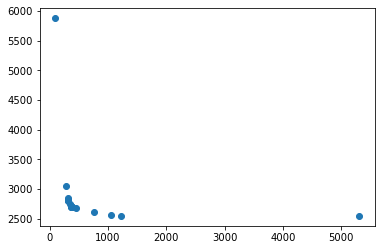

In [630]:
plt.scatter(f2_2[1:],f1_2[1:])

In [631]:
## Configuration 3
p = 0.2
rl = 0.85
objective_vals = []
for Dict in dictionaries:
    run_Model(p, rl, Dict)
    objective_vals.append([Dict['f1'], Dict['f2'], Cost_dict['f1'], Cost_dict['f2'], Summary_dict["OpenMPs"], Summary_dict["OpenDCs"]])

obj val:  0.0
obj val:  307.76508132805424
obj val:  512.2126353277971
obj val:  648.8225191109751
obj val:  777.0490731003479
obj val:  900.6404968286259
obj val:  1022.3305009562547
obj val:  1143.9513031715767
obj val:  1265.269415146225
obj val:  1386.464213909402
obj val:  1507.290230922689
obj val:  1627.7114244573838
obj val:  1747.7176961408838
obj val:  1867.1639163800799
obj val:  1985.6267863782284
obj val:  2103.877748617751
obj val:  2222.386212644649
obj val:  2328.293148779636
obj val:  2415.358866156299
obj val:  2488.156457033179
obj val:  2546.144583293276


In [632]:
df_3 = pd.DataFrame((objective_vals), columns = ["f1 weight", "f2 weight", "f1", "f2", "Plants", "DCs"])
df_3

,f1 weight,f2 weight,f1,f2,Plants,DCs
0,0.00,1.00,147556.95,0.0,2.0,3.0
1,0.05,0.95,6155.17,0.0,2.0,3.0
2,0.10,0.90,2973.71,253.0,2.0,3.0
3,0.15,0.85,2828.64,279.0,2.0,3.0
4,0.20,0.80,2828.68,279.0,2.0,3.0
5,0.25,0.75,2726.00,310.0,2.0,3.0
6,0.30,0.70,2726.00,310.0,2.0,3.0
7,0.35,0.65,2722.10,310.0,2.0,3.0
8,0.40,0.60,2720.24,304.0,2.0,3.0
9,0.45,0.55,2715.33,304.0,2.0,3.0


In [636]:
f2_3 = list(df_3['f2'])
f1_3 = list(df_3['f1'])

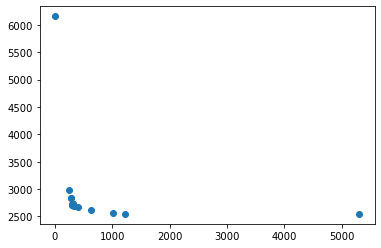

In [637]:
plt.scatter(f2_3[1:], f1_3[1:])

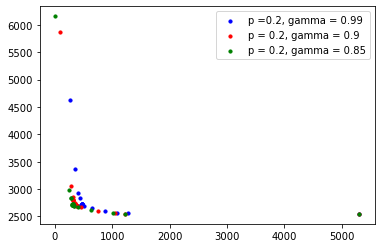

In [638]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(f2_1[1:], f1_1[1:], s=10, c='b', marker="o", label='p =0.2, gamma = 0.99')
ax1.scatter(f2_2[1:], f1_2[1:], s=10, c='r', marker="o", label='p = 0.2, gamma = 0.9')
ax1.scatter(f2_3[1:], f1_3[1:], s=10, c='g', marker="o", label='p = 0.2, gamma = 0.85')

plt.legend(loc='upper right');
plt.show()